# HW6

Your goal this week is to implement PPO and apply it to the simple pendulum. The main reference for PPO is Schulman et al (2017).

You can think of PPO as a natural extension of REINFORCE (which you implemented in HW4 and HW5), where we are now using a deep net both to describe the policy (actor) and the value function (critic).

In particular, a key step will be to implement the loss function in Eq. (9) of Schulman et al (2017). The input to the deep net should be the continuous state (joint angle, joint velocity). The output from the deep net should be both the mean and variance of a normal distribution from which the continuous action (joint torque) is sampled - a so-called "Gaussian policy" - and the value of the state. You are free to drop the "entropy bonus" term from Eq. (9). Note that pytorch and tensorflow will compute the gradient of the loss function for you - there is no need to derive an expression for the gradient yourself, as you did in HW4 for the tabular policy.

Your implementation should be designed so that it can be used with arbitrary continuous-state/continuous-action gym environments. In particular, you should aspire to apply your same algorithm to the acrobot (where the deep net would output the mean and covariance of a multi-variate normal distribution as well as the value), once you have successfully applied it to the simple pendulum.

Follow the same pattern as with previous homework - choose hyperparameters so that the training converges, plot the learning rate, and so forth.

## Setting up hyperparameters

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import os

# Run on CPU instead of GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Define number of episodes and time horizon
episode_num = 512
time_horizon = 256

# Discount rate and learning rate for actor and critic network
gamma = 0.9
lr_a = 0.0001 # Actor network learning rate
lr_c = 0.0002 # Critic network learning rate

# Batch size
BATCH = 32

# Number of update within each Batch
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10

# State and action dimension
S_DIM = 3 
A_DIM = 1

No GPU found


## Memory and post process module

In [2]:
# Define Memory for saving state, action and reward of each mini-batch
class Memory(object):
    def __init__(self):
        self.ep_obs, self.ep_act, self.ep_rwd = [], [], []

    def store_transition(self, obs0, act, rwd):
        self.ep_obs.append(obs0)
        self.ep_act.append(act)
        self.ep_rwd.append(rwd)

    def covert_to_array(self):
        array_obs = np.vstack(self.ep_obs)
        array_act = np.vstack(self.ep_act)
        array_rwd = np.array(self.ep_rwd)
        return array_obs, array_act, array_rwd

    def reset(self):
        self.ep_obs, self.ep_act, self.ep_rwd = [], [], []

# Post processing unit for showing resl
class PostProcess(object):
    def __init__(self):
        self.ep_reward = 0
        self.total_reward = []
        self.traj = []
        self.opt_traj = []

    def rew_acu(self, reward, s):
        self.ep_reward = self.ep_reward + reward
        self.traj.append(s)

    def push(self, episode):
        if ep == 0:
            self.total_reward.append(self.ep_reward)
        else:
            self.total_reward.append(self.ep_reward*0.1 + self.total_reward[-1]*0.9)
        #print('epoch',episode,' | reward', self.ep_reward)

        self.opt_traj = self.traj

        self.traj = []
        self.ep_reward = 0

    def graph(self):
        plt.figure(0)
        plt.plot(self.total_reward)
        plt.figure(1)
        [s,c,dt] = plt.plot(range(256), self.opt_traj)
        plt.legend([s,c,dt], ["sin(theta)","cos(theta)","dtheta"], loc=1)
        plt.show()

        print(np.shape(self.opt_traj[:][0]))

    def get_reward(self):
        return self.total_reward

    def reset(self):
        self.ep_reward = 0
        self.total_reward = []


## Proximal Policy Optimizer (PPO) module

In [3]:
# Main Agent for implemntation of PPO
class PPO(object):

    def __init__(self):
        self.input = tf.placeholder(tf.float32, [None, S_DIM], 'state')
        self.memory = Memory()

        # critic
        with tf.variable_scope('critic'):
            self.v = self._build_cnet('critic', trainable= True)
            self.q_value = tf.placeholder(tf.float32, [None, 1], 'q_value')
            self.advantage = self.q_value - self.v

            self.critic_loss = tf.reduce_mean(tf.square(self.advantage))
            self.critic_op = tf.train.AdamOptimizer(lr_c).minimize(self.critic_loss)

        # actor
        policy, policy_params = self._build_anet('policy', trainable=True)
        old_policy, old_policy_params = self._build_anet('old_policy', trainable=False)

        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(policy.sample(1), axis=0)       # choosing action
        with tf.variable_scope('update_old_policy'):
            self.update_old_policy_op = [oldp.assign(p) for p, oldp in zip(policy_params, old_policy_params)]

        self.act = tf.placeholder(tf.float32, [None, A_DIM], 'action')
        self.adv = tf.placeholder(tf.float32, [None, 1], 'advantage')

        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                ratio = policy.prob(self.act) / old_policy.prob(self.act)
                self.actor_loss = -tf.reduce_mean(tf.minimum(
                    ratio * self.adv,
                    tf.clip_by_value(ratio, 1.-0.2, 1.+0.2)*self.adv))

        with tf.variable_scope('atrain'):
            self.actor_op = tf.train.AdamOptimizer(lr_a).minimize(self.actor_loss)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def update(self):
        state, action, reward = self.memory.covert_to_array()
        self.memory.reset()
        a = self.get_q(state[-1][:], reward)

        self.sess.run(self.update_old_policy_op)
        adv = self.sess.run(self.advantage, {self.input: state, self.q_value: a})

        # update actor
        [self.sess.run(self.actor_op, {self.input: state, self.act: action, self.adv: adv}) for _ in range(A_UPDATE_STEPS)]

        # update critic
        [self.sess.run(self.critic_op, {self.input: state, self.q_value: a}) for _ in range(C_UPDATE_STEPS)]

    def _build_cnet(self, name, trainable):
        with tf.variable_scope(name):
            l1 = tf.layers.dense(self.input, 100, tf.nn.relu)
            v = tf.layers.dense(l1, 1)
        return v


    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            l1 = tf.layers.dense(self.input, 100, tf.nn.relu, trainable=trainable)
            mu = 2 * tf.layers.dense(l1, A_DIM, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(l1, A_DIM, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params

    def choose_action(self, s):
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.input: s})[0]
        return np.clip(a, -2, 2)

    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.input: s})[0, 0]

    def get_q(self, s, reward):
        v_s_ = self.get_v(s)
        discounted_r = []
        for r in reward[::-1]:
            v_s_ = r + gamma * v_s_
            discounted_r.append(v_s_)
        discounted_r.reverse()
        return np.array(discounted_r)[:, np.newaxis]

## Pendulum-V0 in loop

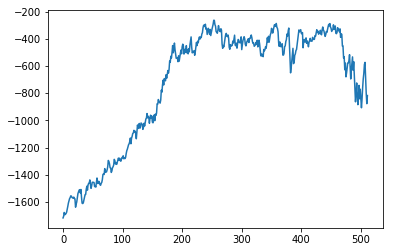

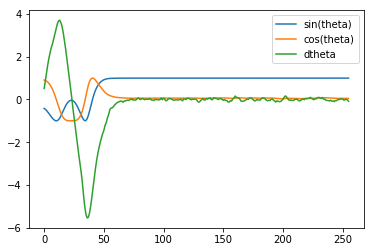

(3,)


In [4]:
env = gym.make('Pendulum-v0').unwrapped
ppo = PPO()
pporcess = PostProcess()

for ep in range(episode_num):
    s = env.reset()
    for t in range(time_horizon):    # in one episode

        '''if ep >= 300:
            env.render()'''

        a = ppo.choose_action(s)
        s_, r, done, _ = env.step(a) 

        ppo.memory.store_transition(s, a, (r+8)/8)

        s = s_
        
        pporcess.rew_acu(r, s)

        # update ppo
        if (t+1) % BATCH == 0 or t == time_horizon-1:
            ppo.update()

    pporcess.push(ep)

pporcess.graph()
env.close()

## Analysis of results

As is obvious from reward plot the algorithm is able to converge in less than 500 epochs however since there is penalty on control effort, in some cases where pendulum is on upright position we get poor reward since actor exerts too much torque. In addition in some cases we get too much oscilation before converging to upright position hence lower reward. \\
Second plot is example trajectory. As you can see at the $t \geq 50$ we have $$sin(\theta) = 1 $$ and $$cos(\theta) = 0$$ meaning that $$theta = \frac{\pi}{2}$$ additionally $$\dot{\theta}=0$$